In [1]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'


In [2]:
# load data_clean
df = pd.read_csv("../data_light/data_clean.csv").sort_values(by="year")
df.gender = df.gender.apply(lambda x: 1 if x == "female" else 0)
# drop 2023
df = df[df.year != 2023]
years = df['year'].unique()

In [2]:
# no. edges, no.nodes, components, edges/nodes ratios lists
no_edges = []
no_nodes = []
no_components = []
edges_nodes_ratios = []

years = df['year'].unique()

# Create a graph for each year
for year in years:
    # create a dataframe for the current year
    df_year = df[df['year'] == year]
    
    # Group researchers per publication
    groups = df_year.groupby('pub_id')['researcher_id'].apply(list)
    
    # create a dictionary to store the collaboration count for each pair of authors
    collaboration_count = {}
    
    # count the collaborations among authors
    for group in groups:
        for pair in itertools.combinations(group, 2):
            if pair in collaboration_count:
                collaboration_count[pair] += 1
            else:
                collaboration_count[pair] = 1
    
    # create the graph
    G = nx.Graph()
    
    # add the nodes
    for author in df_year['researcher_id'].unique():
        G.add_node(author)
    
    # add the weighted edges
    for pair, weight in collaboration_count.items():
        author1, author2 = pair
        G.add_edge(author1, author2, weight=weight)
    
    # no edges and nodes
    print(f"Year: {year}")
    no_edges.append(G.number_of_edges())
    no_nodes.append(G.number_of_nodes())
    no_components.append(nx.number_connected_components(G))
    edges_nodes_ratios.append(G.number_of_edges()/G.number_of_nodes())
    
    # save the graph
    nx.write_graphml(G, f"graphs/{year}.graphml")

# create a dataframe with the results

df_results = pd.DataFrame({'year': years,
                           'no_edges': no_edges,
                           'no_nodes': no_nodes,
                           'no_components': no_components,
                           'edges_nodes_ratios': edges_nodes_ratios})


Year: 2007
Year: 2008
Year: 2009
Year: 2010
Year: 2011
Year: 2012
Year: 2013
Year: 2014
Year: 2015
Year: 2016
Year: 2017
Year: 2018
Year: 2019
Year: 2020
Year: 2021
Year: 2022
Year: 2023


In [21]:
df_results.head()

,year,no_edges,no_nodes,no_components,edges_nodes_ratios
0,2007,41581,9429,1319,4.409906
1,2008,43002,9726,1349,4.421345
2,2009,48495,10653,1425,4.552239
3,2010,52742,10426,1334,5.058699
4,2011,57718,11247,1423,5.131857


In [26]:
# create a dataframe for statistics per year

df_stats = pd.DataFrame({'no_authors': df.groupby('year')['researcher_id'].nunique(),
                         'no_publications': df.groupby('year')['pub_id'].nunique(),
                         'perc_LMIC': df.groupby('year')['LMIC'].mean(),
                         'perc_female': df.groupby('year')['gender'].mean(),
                         'no_publications_per_author': df.groupby('year')['pub_id'].nunique()/df.groupby('year')['researcher_id'].nunique(),
                         'no_author_per_publication': df.groupby('year')['researcher_id'].nunique()/df.groupby('year')['pub_id'].nunique()
                        })
df_stats.head()

,no_authors,no_publications,perc_LMIC,perc_female,no_publications_per_author,no_author_per_publication
year,,,,,,
2007,9429,2085,0.072938,0.265616,0.221126,4.522302
2008,9726,2150,0.080647,0.259099,0.221057,4.523721
2009,10653,2358,0.067710,0.262326,0.221346,4.517812
2010,10426,2276,0.088520,0.290933,0.218300,4.580844
2011,11247,2468,0.074362,0.275200,0.219436,4.557131


In [28]:
# merge the two dataframes, stats and results
df_results = df_results.merge(df_stats, left_on='year', right_on='year')

In [41]:
# only keep the columns we need for ploting
df_to_plot = df_results[['year',
                         'no_authors',
                         'no_publications',
                         'no_edges',
                         'edges_nodes_ratios',
                         'no_author_per_publication',
                         'no_publications_per_author',
                         'perc_LMIC',
                         'perc_female']].set_index('year')

In [42]:
df_to_plot.head()

,no_authors,no_publications,no_edges,edges_nodes_ratios,no_author_per_publication,no_publications_per_author,perc_LMIC,perc_female
year,,,,,,,,
2007,9429,2085,41581,4.409906,4.522302,0.221126,0.072938,0.265616
2008,9726,2150,43002,4.421345,4.523721,0.221057,0.080647,0.259099
2009,10653,2358,48495,4.552239,4.517812,0.221346,0.067710,0.262326
2010,10426,2276,52742,5.058699,4.580844,0.218300,0.088520,0.290933
2011,11247,2468,57718,5.131857,4.557131,0.219436,0.074362,0.275200


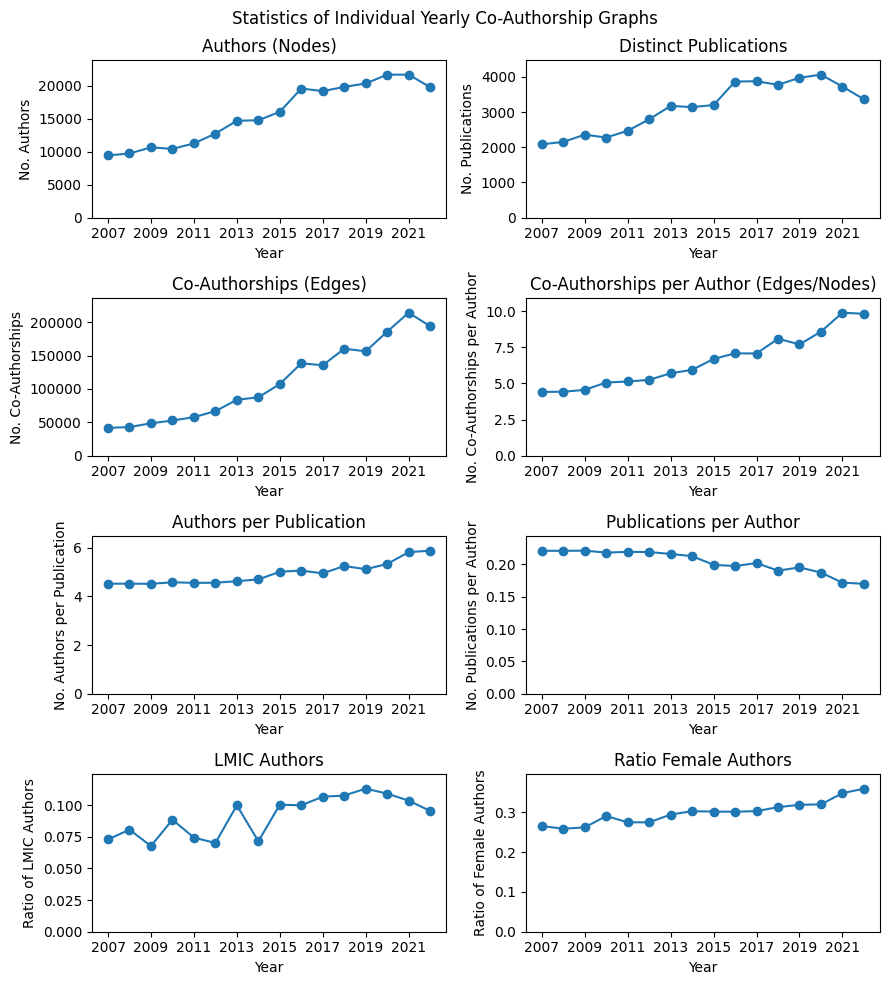

In [54]:
# create 4x2 subplot figure, 4 rows, 2 columns, A4 size
# create list with subtitles
xx_labels = ['No. Authors', 'No. Publications', 'No. Co-Authorships', 'No. Co-Authorships per Author',
             'No. Authors per Publication', 'No. Publications per Author', 'Ratio of LMIC Authors', 'Ratio of Female Authors']

subtitles = ['Authors (Nodes)', 'Distinct Publications', 'Co-Authorships (Edges)', 'Co-Authorships per Author (Edges/Nodes)',
             'Authors per Publication', 'Publications per Author', 'LMIC Authors', 'Ratio Female Authors']
             

fig, axs = plt.subplots(4, 2, figsize=(9, 10))

# loop through the columns
for i, c in enumerate(df_to_plot.columns):
    # plot the data
    axs[i//2, i%2].plot(df_to_plot.index, df_to_plot[c], marker='o')
    # set the title
    axs[i//2, i%2].set_title(subtitles[i])
    # set the x label
    axs[i//2, i%2].set_xlabel('Year')
    # set the y label
    axs[i//2, i%2].set_ylabel(xx_labels[i])
    # set the y limit
    axs[i//2, i%2].set_ylim(bottom=0, top=df_to_plot[c].max() + 0.1*df_to_plot[c].max())
    # set x ticks, but only for some years
    axs[i//2, i%2].set_xticks(df_to_plot.index[::2])

    
# super title
fig.suptitle('Statistics of Individual Yearly Co-Authorship Graphs')

# adjust the layout
plt.tight_layout()

# show the plot
plt.show()

# save the plot
fig.savefig('results/year_graphs_summary.png', dpi=1000)

In [ ]:
df_edge_types = pd.DataFrame(index=years, columns=['F-F', 'F-M', 'M-M'])

# loop through the years
for year in tqdm(years):
    G_i = nx.read_graphml(f'graphs/{year}.graphml')
    edges_i = G_i.edges()
    df_i = df[df['year'] == year][['researcher_id', 'gender']].drop_duplicates().set_index('researcher_id')

    mapping = {0: 'M-M', 1: 'F-F'}

    edge_types = []
    for source, target in edges_i:
        source_gender = df_i.loc[source, 'gender']
        target_gender = df_i.loc[target, 'gender']

        if source_gender == target_gender:
            edge_types.append(mapping[source_gender])
        else:
            edge_types.append('F-M')

    df_edgetypes = pd.DataFrame({'edge_type': edge_types})
    counts = df_edgetypes['edge_type'].value_counts(normalize=True)

    # append the counts to the dataframe
    df_edge_types.loc[year, 'F-F'] = counts['F-F']
    df_edge_types.loc[year, 'F-M'] = counts['F-M']
    df_edge_types.loc[year, 'M-M'] = counts['M-M']

# Transform into percentages
df_edge_types = df_edge_types*100


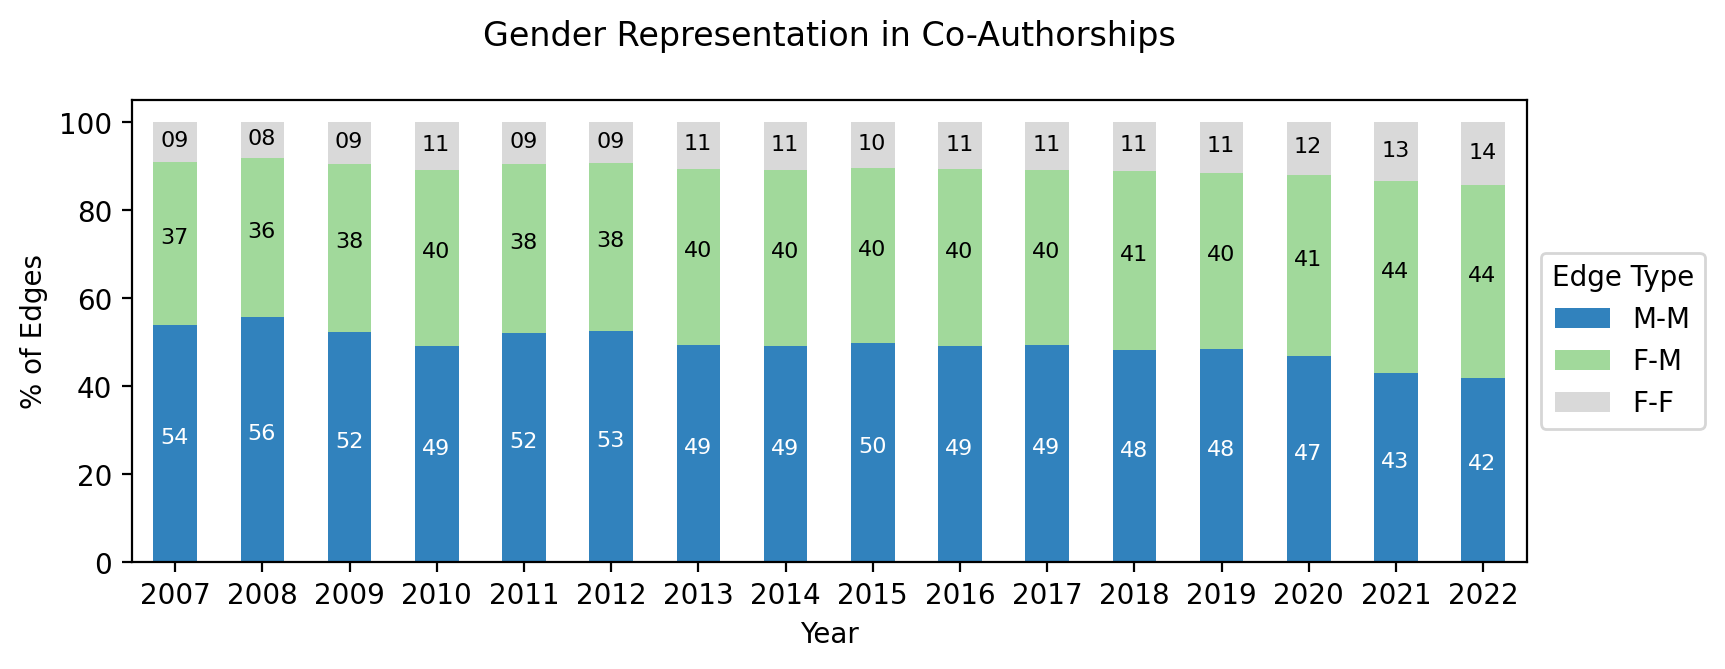

In [65]:
# plot the results, year in the x axis, percentage in the y axis, different colors and legend
# reorder to be M-M, F-M, F-F
df_edge_types = df_edge_types[['M-M', 'F-M', 'F-F']]
# transform into percentages
df_edge_types.plot(kind='bar', stacked=True, figsize=(9, 3), rot=0, colormap='tab20c')

# add text labels to the bars, individually, in the middle of each, different colors
for i, year in enumerate(years):
    plt.text(i-.17, df_edge_types.loc[year, 'M-M']/2, f"{df_edge_types.loc[year, 'M-M']:.1f}%", color='white', fontsize=8)
    plt.text(i-.17, df_edge_types.loc[year, 'M-M'] + df_edge_types.loc[year, 'F-M']/2, f"{df_edge_types.loc[year, 'F-M']:.1f}%", color='black', fontsize=8)
    plt.text(i-.17, df_edge_types.loc[year, 'M-M'] + df_edge_types.loc[year, 'F-M'] + df_edge_types.loc[year, 'F-F']/2-1, f"{df_edge_types.loc[year, 'F-F']:.1f}%", color='black', fontsize=8)

plt.title('Gender Representation in Co-Authorships\n')
plt.xlabel('Year')
plt.ylabel('% of Edges')
plt.legend(loc='upper left', bbox_to_anchor=(1, .7), title='Edge Type')
plt.show()


In [66]:
df_edge_types = pd.DataFrame(index=years, columns=['H-H', 'L-L', 'H-L'])

# loop through the years
for year in tqdm(years):
    G_i = nx.read_graphml(f'graphs/{year}.graphml')
    edges_i = G_i.edges()
    df_i = df[df['year'] == year][['researcher_id', 'LMIC']].drop_duplicates().set_index('researcher_id')

    mapping = {0: 'H-H', 1: 'L-L'}

    edge_types = []
    for source, target in edges_i:
        source_LMIC = df_i.loc[source, 'LMIC']
        target_LMIC = df_i.loc[target, 'LMIC']

        if source_LMIC == target_LMIC:
            edge_types.append(mapping[source_LMIC])
        else:
            edge_types.append('L-H')

    df_edgetypes = pd.DataFrame({'edge_type': edge_types})
    counts = df_edgetypes['edge_type'].value_counts(normalize=True)

    # append the counts to the dataframe
    df_edge_types.loc[year, 'L-L'] = counts['L-L']
    df_edge_types.loc[year, 'L-H'] = counts['L-H']
    df_edge_types.loc[year, 'H-H'] = counts['H-H']

# Transform into percentages
df_edge_types = df_edge_types*100


100%|██████████| 16/16 [06:37<00:00, 24.86s/it]


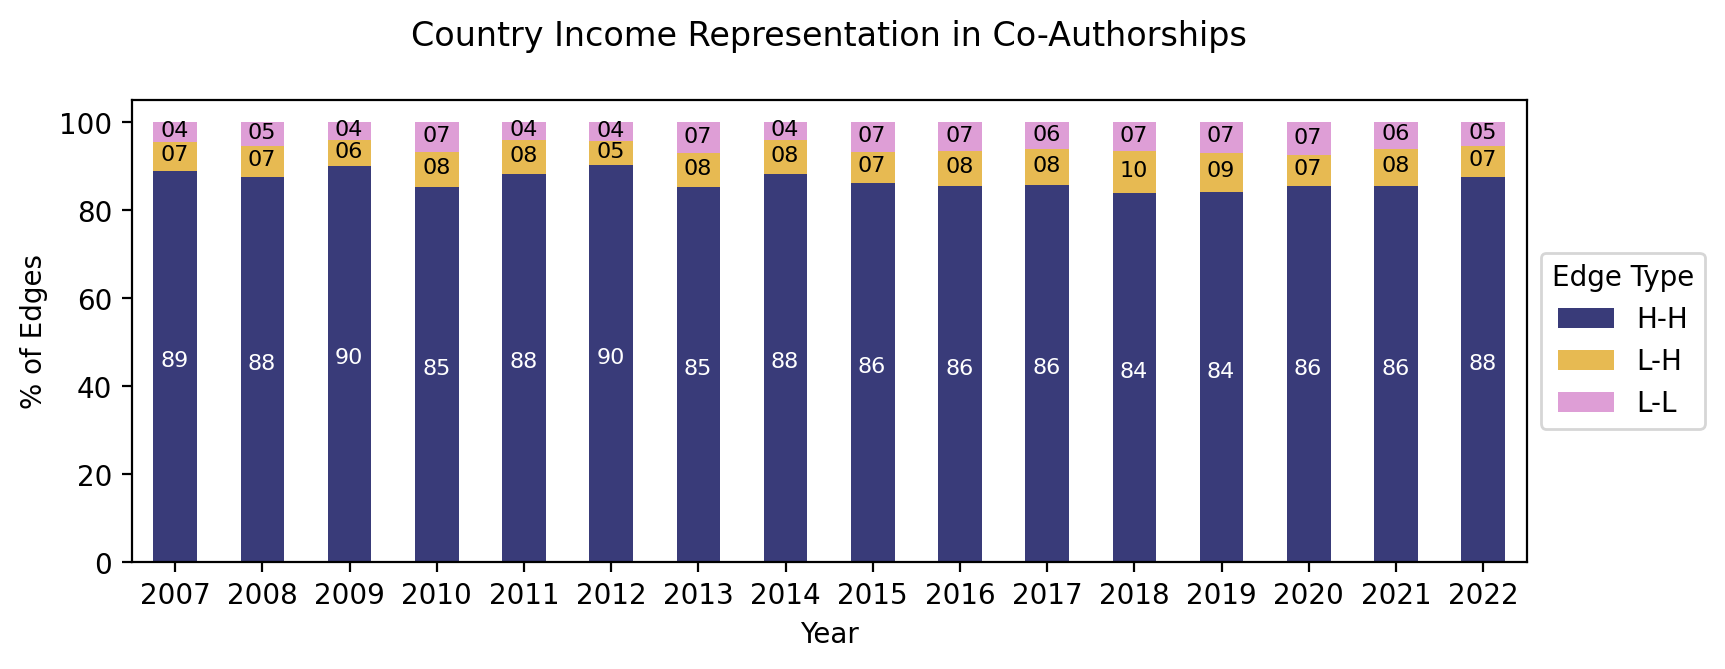

In [74]:
# plot the results, year in the x axis, percentage in the y axis, different colors and legend
# reorder to be M-M, F-M, F-F
df_edge_types = df_edge_types[['H-H', 'L-H', 'L-L']]
# transform into percentages
df_edge_types.plot(kind='bar', stacked=True, figsize=(9, 3), rot=0, colormap='tab20b')

# add text labels to the bars, individually, in the middle of each, different colors
for i, year in enumerate(years):
    plt.text(i-.17, df_edge_types.loc[year, 'H-H']/2, f"{df_edge_types.loc[year, 'H-H']:.1f}%", color='white', fontsize=8)
    plt.text(i-.17, df_edge_types.loc[year, 'H-H'] + df_edge_types.loc[year, 'L-H']/2-1, f"{df_edge_types.loc[year, 'L-H']:.1f}%", color='black', fontsize=8)
    plt.text(i-.17, df_edge_types.loc[year, 'H-H'] + df_edge_types.loc[year, 'L-H'] + df_edge_types.loc[year, 'L-L']/2-1, f"{df_edge_types.loc[year, 'L-L']:.1f}%", color='black', fontsize=8)

plt.title('Country Income Representation in Co-Authorships\n')
plt.xlabel('Year')
plt.ylabel('% of Edges')
plt.legend(loc='upper left', bbox_to_anchor=(1, .7), title='Edge Type')
plt.show()


In [19]:
# create graphs for bins of 4 years
# 2007-2010, 2011-2014, 2015-2018, 2019-2022

# create a list of lists with the years
years_bins = [[2007, 2008, 2009, 2010],
              [2011, 2012, 2013, 2014],
              [2015, 2016, 2017, 2018],
              [2019, 2020, 2021, 2022]]

# create a list of lists with the graphs
graphs_bins = []

# loop through the years
for years_bin in years_bins:
    # create a dataframe for the current year
    df_bin = df[df['year'].isin(years_bin)]
    
    # Group researchers per publication
    groups = df_bin.groupby('pub_id')['researcher_id'].apply(list)
    
    # create a dictionary to store the collaboration count for each pair of authors
    collaboration_count = {}
    
    # count the collaborations among authors
    for group in groups:
        for pair in itertools.combinations(group, 2):
            if pair in collaboration_count:
                collaboration_count[pair] += 1
            else:
                collaboration_count[pair] = 1
    
    # create the graph
    G = nx.Graph()
    
    # add the nodes
    for author in df_bin['researcher_id'].unique():
        G.add_node(author)
    
    # add the weighted edges
    for pair, weight in collaboration_count.items():
        author1, author2 = pair
        G.add_edge(author1, author2, weight=weight)
    
    # save the graph
    graphs_bins.append(G)


In [28]:
df_edge_types = pd.DataFrame(index=[y[0] for y in years_bins], columns=['LF-LF','LM-LM', 'LM-LF', 'HF-HF', 'HM-HM', 'HM-HF', 'LF-HF', 'LM-HM', 'LM-HF'])

#Create a mapping dictionary to define the edge types
edge_type_mapping = {
    (1,1,1,1): 'LF-LF',
    (1,0,1,0): 'LM-LM',
    (1,0,1,1): 'LM-LF',
    (0,1,0,1): 'HF-HF',
    (0,0,0,0): 'HM-HM',
    (0,0,0,1): 'HM-HF',
    (1,1,0,1): 'LF-HF',
    (1,0,0,0): 'LM-HM',
    (1,0,0,1): 'LM-HF'
}

# loop through the years
for i, years_bin in tqdm(enumerate(years_bins)):
    G_i = graphs_bins[i]
    edges_i = G_i.edges()
    
    df_i = df[df['year'].isin(years_bin)][['researcher_id', 'gender','LMIC']].drop_duplicates().set_index('researcher_id')

    # Create an empty list to store the edge types
    edge_types = []

    # Iterate over the edges of the graph
    for source, target in edges_i:
        source_gender = df_i.loc[source, 'gender']
        source_income = df_i.loc[source, 'LMIC']
        target_gender = df_i.loc[target, 'gender']
        target_income = df_i.loc[target, 'LMIC']
        
        edge_type = edge_type_mapping.get((source_income, source_gender, target_income, target_gender))
    
        edge_types.append(edge_type)

    df_edgetypes = pd.DataFrame({'edge_type': edge_types})
    counts = df_edgetypes['edge_type'].value_counts(normalize=True)

    # # append the counts to the dataframe
    df_edge_types.loc[years_bin[0], 'LF-LF'] = counts.get('LF-LF', 0)
    df_edge_types.loc[years_bin[0], 'LM-LM'] = counts.get('LM-LM', 0)
    df_edge_types.loc[years_bin[0], 'LM-LF'] = counts.get('LM-LF', 0)
    df_edge_types.loc[years_bin[0], 'HF-HF'] = counts.get('HF-HF', 0)
    df_edge_types.loc[years_bin[0], 'HM-HM'] = counts.get('HM-HM', 0)
    df_edge_types.loc[years_bin[0], 'HM-HF'] = counts.get('HM-HF', 0)
    df_edge_types.loc[years_bin[0], 'LF-HF'] = counts.get('LF-HF', 0)
    df_edge_types.loc[years_bin[0], 'LM-HM'] = counts.get('LM-HM', 0)
    df_edge_types.loc[years_bin[0], 'LM-HF'] = counts.get('LM-HF', 0)
    
# Transform into percentages
df_edge_types = df_edge_types * 100

4it [05:31, 82.83s/it]


In [29]:
# sort the columns by highest mean
df_edge_types = df_edge_types.reindex(df_edge_types.mean().sort_values(ascending=False).index, axis=1)
df_edge_types

,HM-HM,HM-HF,HF-HF,LM-LM,LM-HM,LM-LF,LM-HF,LF-LF,LF-HF
2007,57.694416,23.036171,10.632079,3.504679,1.965937,1.402434,0.87898,0.603552,0.281751
2011,56.033938,23.581166,11.61453,3.491482,2.135923,1.274028,0.968064,0.513374,0.387494
2015,52.892719,24.194418,12.116016,4.180215,2.490114,1.736374,1.169955,0.806695,0.413493
2019,49.578063,25.342835,14.600906,4.162816,2.018016,1.787549,1.065839,0.890818,0.553157


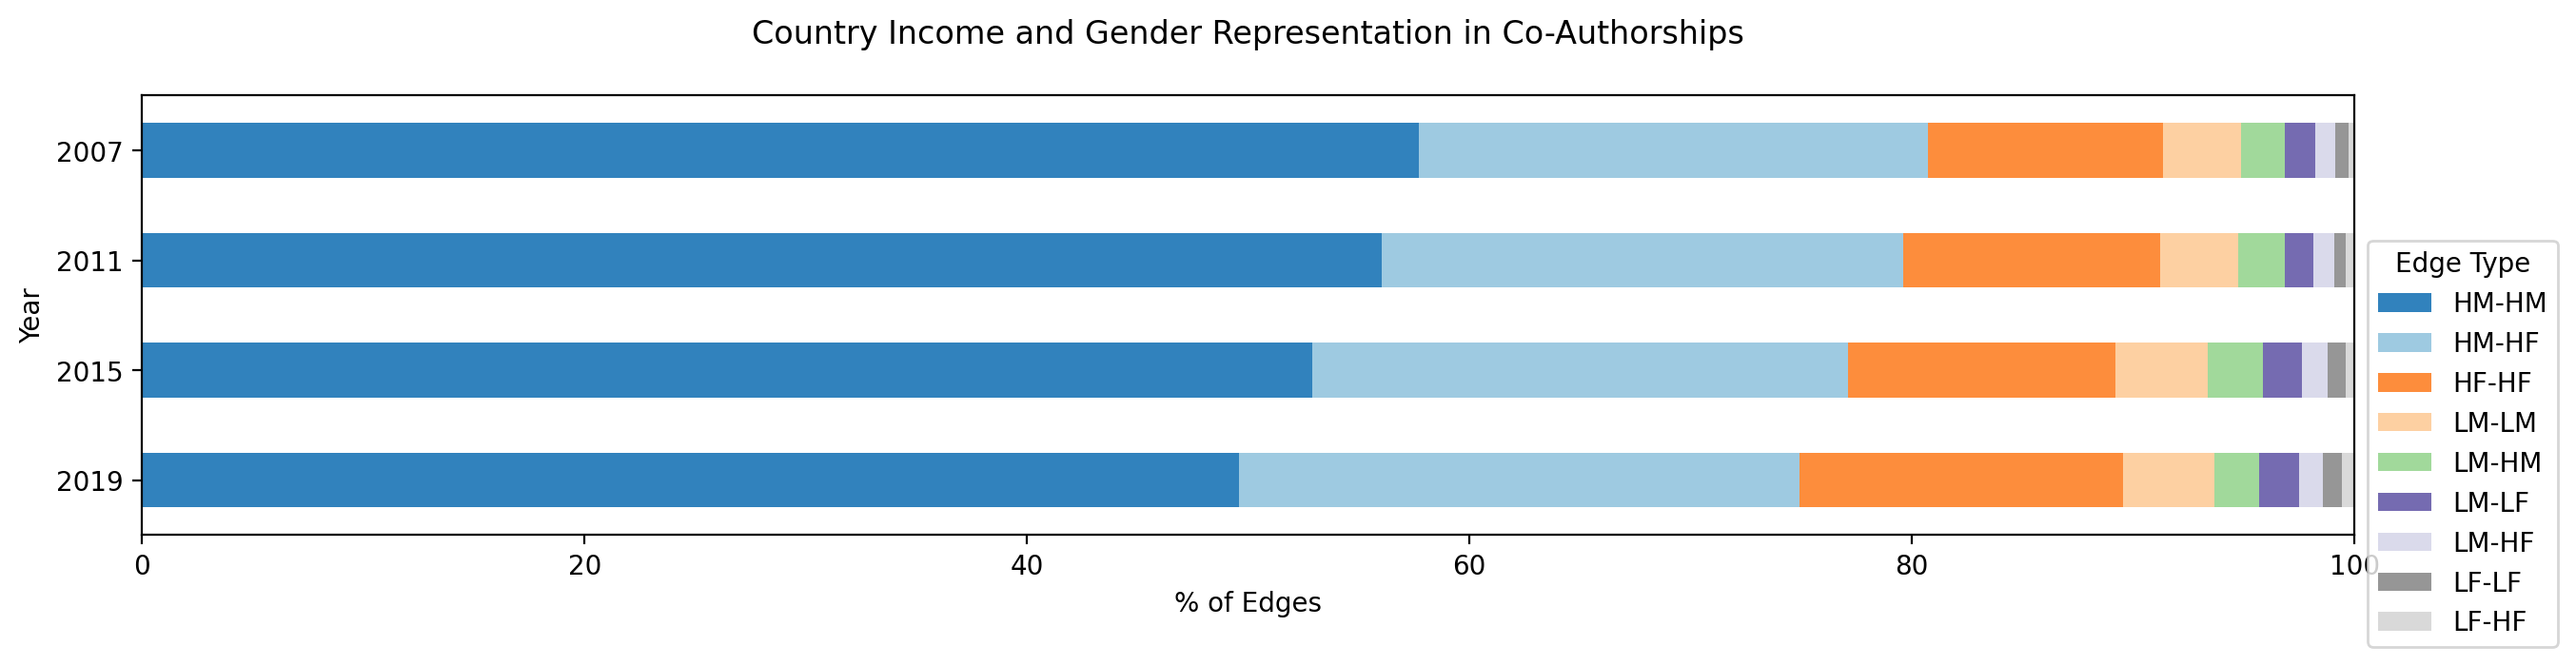

In [43]:
# plot the results, year in the x axis, percentage in the y axis, different colors and legend
# transform into percentages
df_edge_types.iloc[::-1].plot(kind='barh', stacked=True, figsize=(15,3), rot=0, colormap='tab20c')

# add text labels to the bars, individually, in the middle of each, different colors
for i, year in enumerate(years_bins):
    y = year[0]
    

plt.title('Country Income and Gender Representation in Co-Authorships\n')
plt.ylabel('Year')
# plt(['2007\n-2010', '2011\n-2014', '2015\n-2018', '2019\n-2022'])
plt.xlabel('% of Edges')
plt.legend(loc='upper left', bbox_to_anchor=(1, .7), title='Edge Type')
plt.xlim(0, 100)
plt.show()


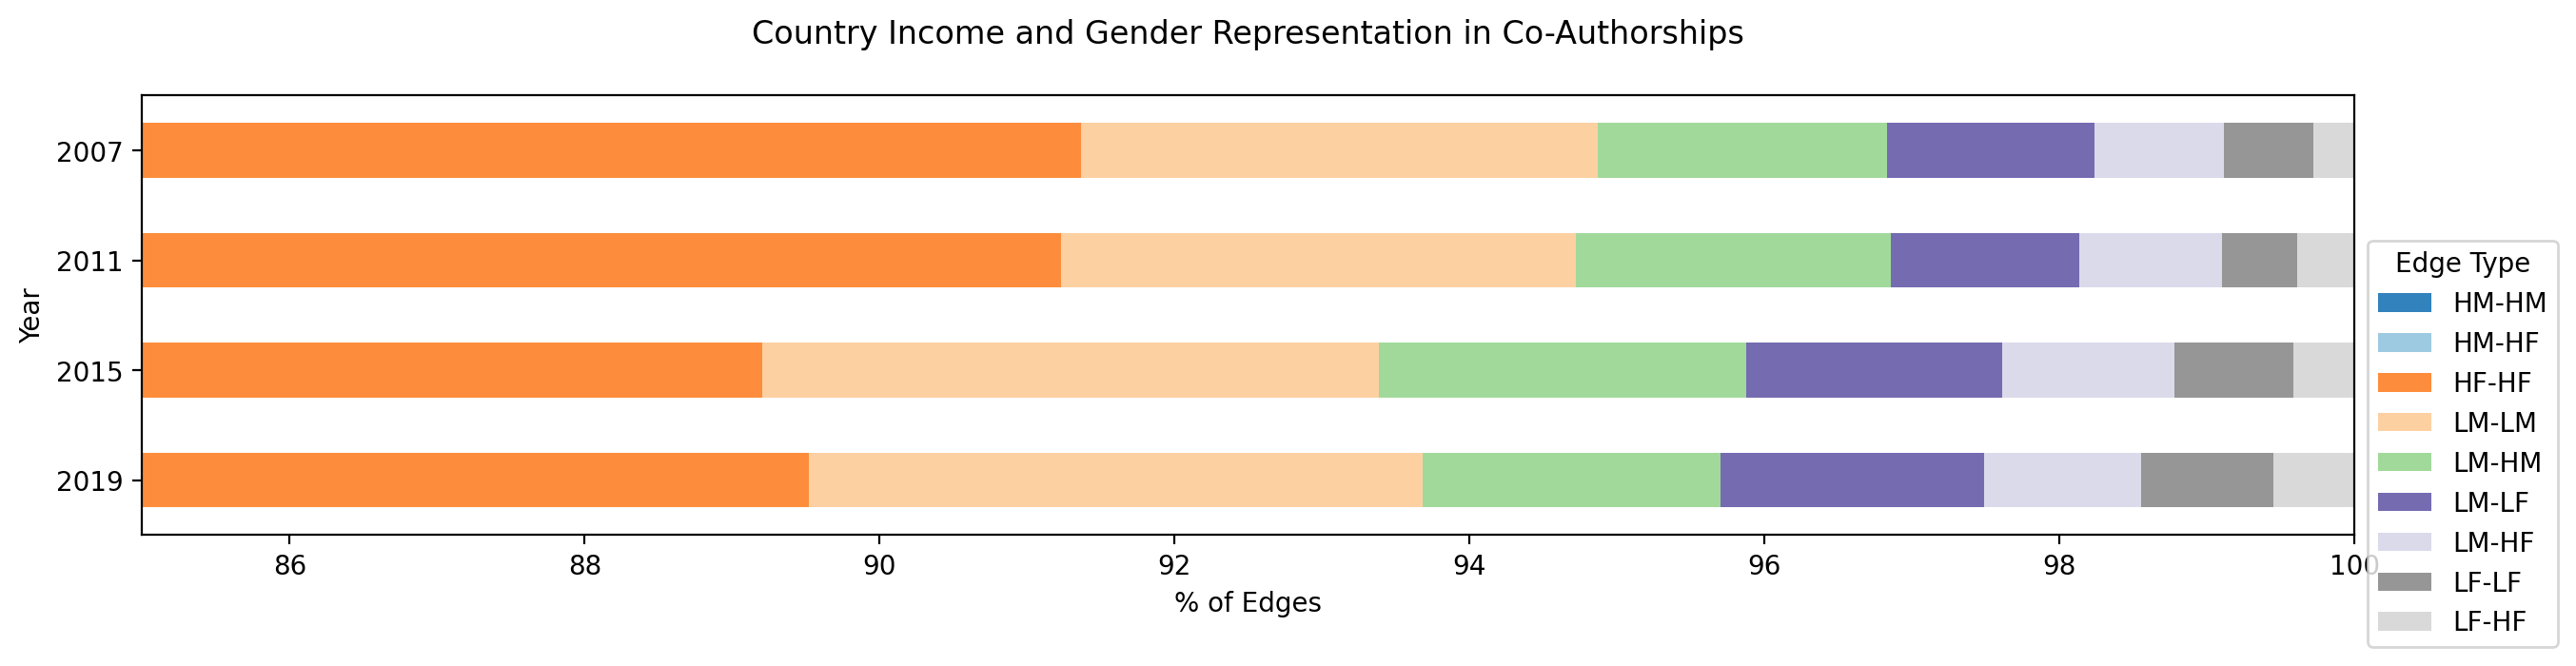

In [42]:
# plot the results, year in the x axis, percentage in the y axis, different colors and legend
# transform into percentages
df_edge_types.iloc[::-1].plot(kind='barh', stacked=True, figsize=(15,3), rot=0, colormap='tab20c')

# add text labels to the bars, individually, in the middle of each, different colors
for i, year in enumerate(years_bins):
    y = year[0]
    

plt.title('Country Income and Gender Representation in Co-Authorships\n')
plt.ylabel('Year')
# plt(['2007\n-2010', '2011\n-2014', '2015\n-2018', '2019\n-2022'])
plt.xlabel('% of Edges')
plt.xlim(85,100)
plt.legend(loc='upper left', bbox_to_anchor=(1, .7), title='Edge Type')
plt.show()


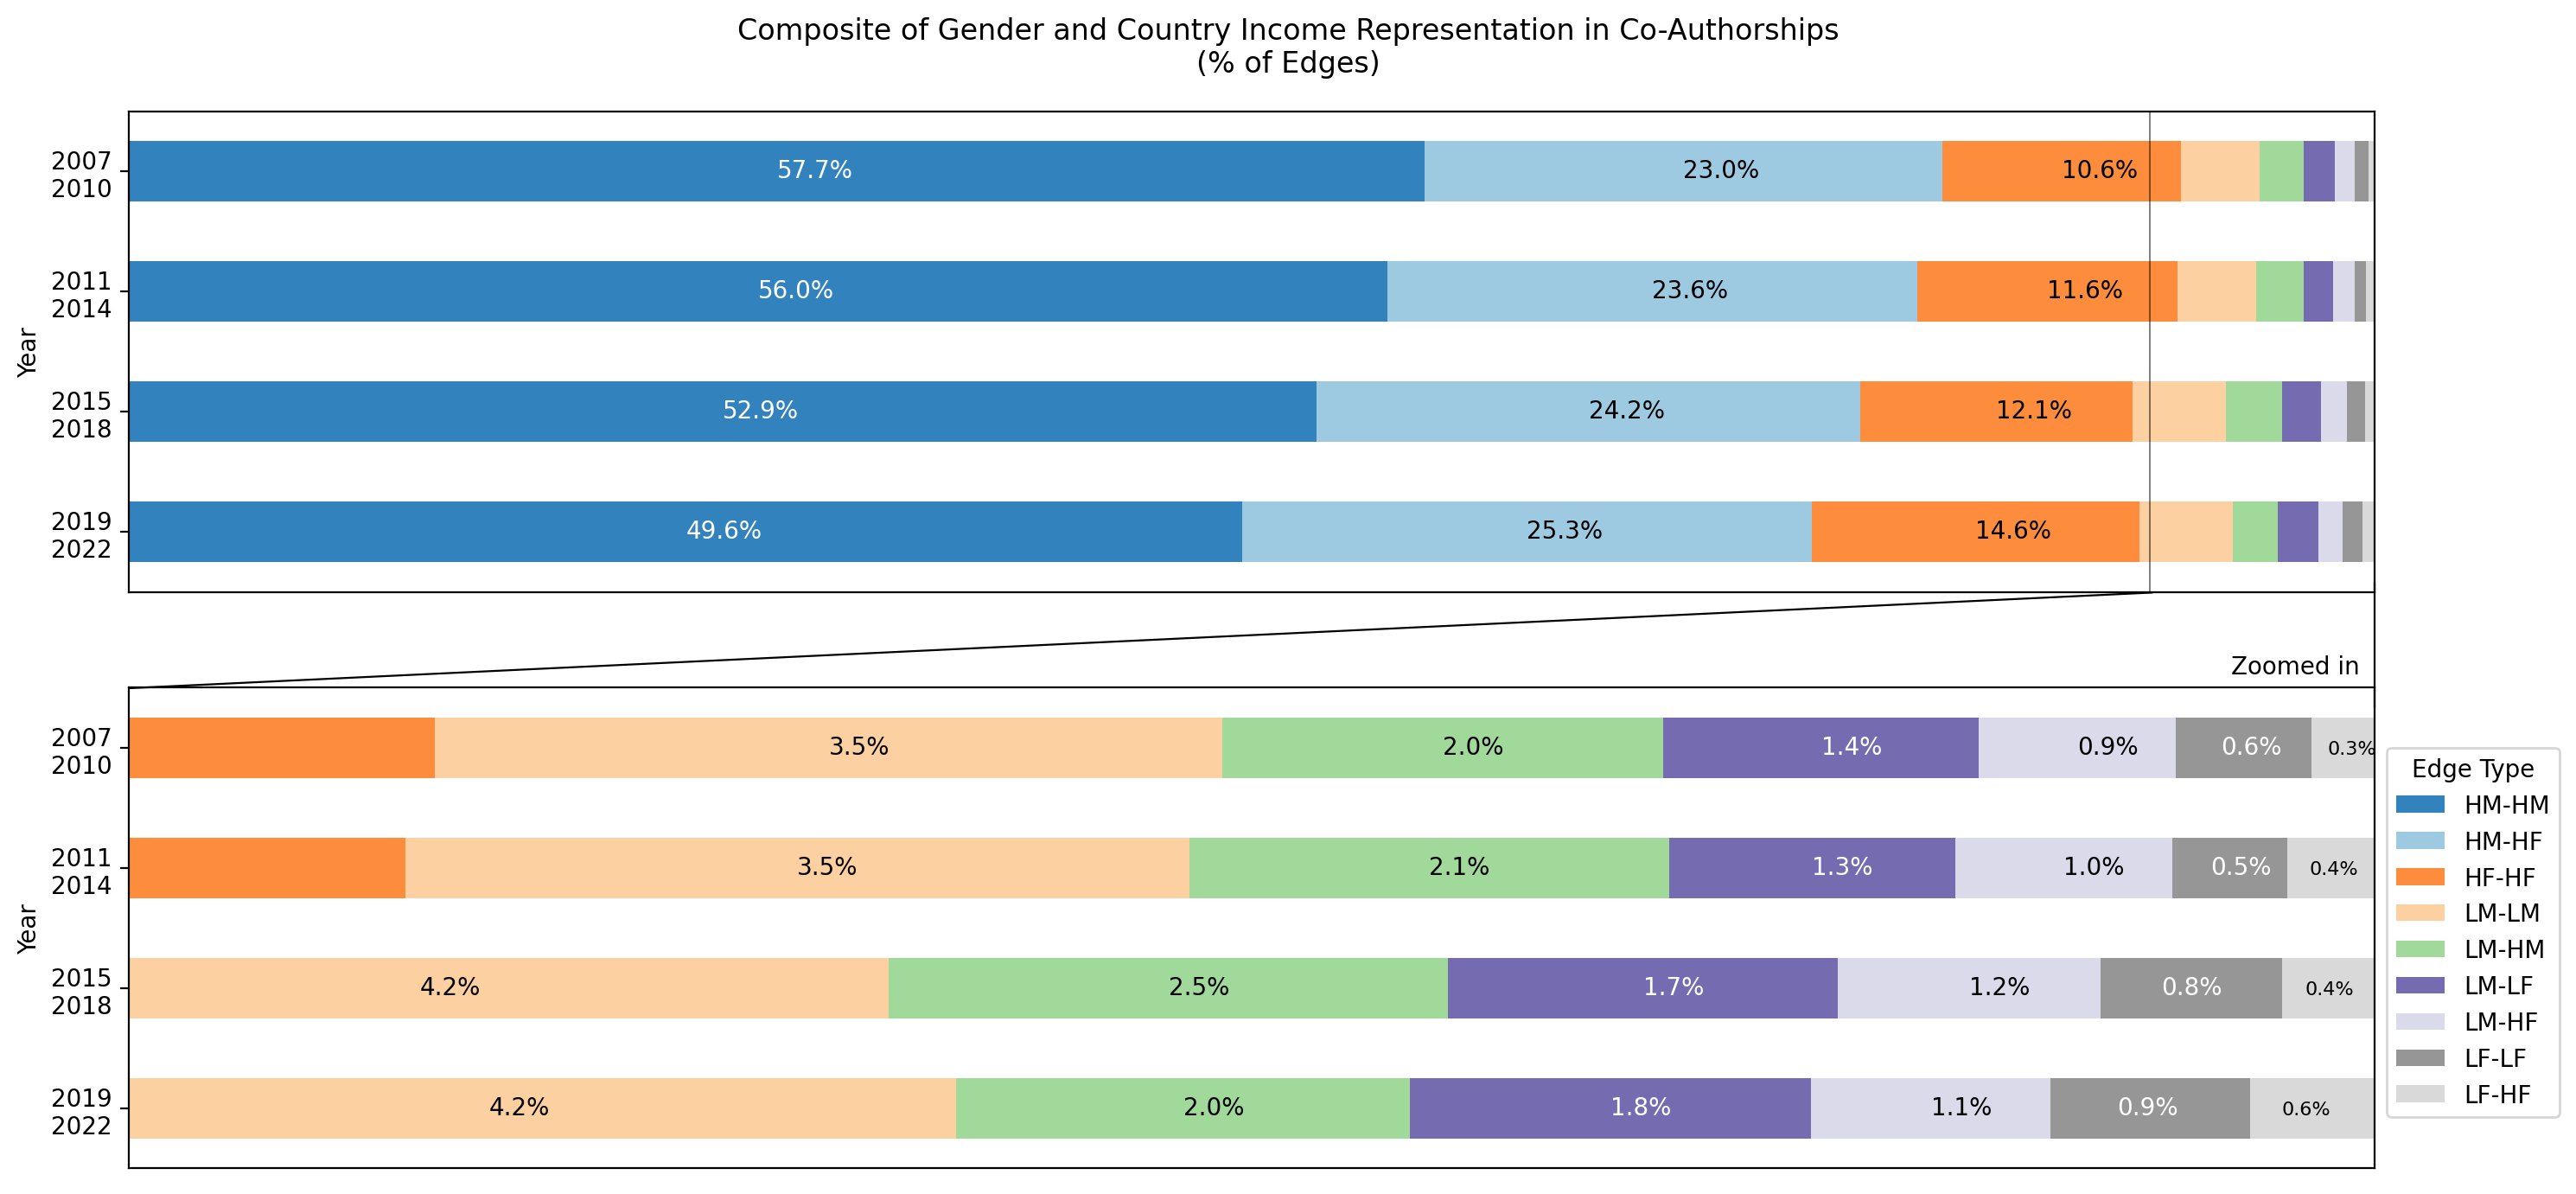

In [147]:
# join both plot above in a same figure
fig, axs = plt.subplots(2, 1, figsize=(15, 7))

d = df_edge_types.iloc[::-1]

d.plot(kind='barh', stacked=True, rot=0, colormap='tab20c', ax=axs[0])
d.plot(kind='barh', stacked=True, rot=0, colormap='tab20c', ax=axs[1])

# add vertical lines, shaded at 90% of the first plot
axs[0].axvline(x=90, color='black', alpha=0.5, linewidth=.7)

# remove the xticks from the first plot
axs[0].set_xticks([])
# remove the xticks from the second plot
axs[1].set_xticks([])

# add ytixks to the first plot
axs[0].set_yticks([0, 1, 2, 3])
axs[0].set_yticklabels(['2007\n2010', '2011\n2014', '2015\n2018', '2019\n2022'][::-1])

# add yticks to the second plot
axs[1].set_yticks([0, 1, 2, 3])
axs[1].set_yticklabels(['2007\n2010', '2011\n2014', '2015\n2018', '2019\n2022'][::-1])


axs[0].set_ylabel('Year')
axs[1].set_ylabel('Year')

axs[0].set_xlim(0, 100)
axs[1].set_xlim(90, 100)
# add title to second plot
axs[1].set_title('\nZoomed in  ', fontsize=10, loc='right')

# omit legend for the first plot
axs[0].legend().set_visible(False)
# add legend for the second plot, outside the plot
axs[1].legend(loc='upper left', bbox_to_anchor=(1, .9), title='Edge Type')

# Add text labels to the bars, individually, in the middle of each, different colors
# for the first plot, only 3 labels

for i, year in enumerate(years_bins[::-1]):
    y = year[0]
    axs[0].text(d.loc[y, 'HM-HM']/2, i-.05, f"{d.loc[y, 'HM-HM']:.1f}%", color='white', fontsize=10)
    axs[0].text(d.loc[y, 'HM-HM'] + d.loc[y, 'HM-HF']/2, i-.05, f"{d.loc[y, 'HM-HF']:.1f}%", color='black', fontsize=10)
    axs[0].text(d.loc[y, 'HM-HM'] + d.loc[y, 'HM-HF'] + d.loc[y, 'HF-HF']/2, i-.05, f"{d.loc[y, 'HF-HF']:.1f}%", color='black', fontsize=10)

# for the second plot, all labels
for i, year in enumerate(years_bins[::-1]):
    y = year[0]
    offset = d.loc[y, 'HM-HM'] + d.loc[y, 'HM-HF'] + d.loc[y, 'HF-HF']
    axs[1].text(offset + d.loc[y, 'LM-LM']/2, i-.05, f"{d.loc[y, 'LM-LM']:.1f}%", color='black', fontsize=10)
    axs[1].text(offset + d.loc[y, 'LM-LM'] + d.loc[y, 'LM-HM']/2, i-.05, f"{d.loc[y, 'LM-HM']:.1f}%", color='black', fontsize=10)
    axs[1].text(offset + d.loc[y, 'LM-LM'] + d.loc[y, 'LM-HM'] + d.loc[y, 'LM-LF']/2, i-.05, f"{d.loc[y, 'LM-LF']:.1f}%", color='white', fontsize=10)
    axs[1].text(offset + d.loc[y, 'LM-LM'] + d.loc[y, 'LM-HM'] + d.loc[y, 'LM-LF'] + d.loc[y, 'LM-HF']/2, i-.05, f"{d.loc[y, 'LM-HF']:.1f}%", color='black', fontsize=10)
    axs[1].text(offset + d.loc[y, 'LM-LM'] + d.loc[y, 'LM-HM'] + d.loc[y, 'LM-LF'] + d.loc[y, 'LM-HF'] + d.loc[y, 'LF-LF']/3, i-.05, f"{d.loc[y, 'LF-LF']:.1f}%", color='white', fontsize=10)
    axs[1].text(offset + d.loc[y, 'LM-LM'] + d.loc[y, 'LM-HM'] + d.loc[y, 'LM-LF'] + d.loc[y, 'LM-HF'] + d.loc[y, 'LF-LF'] + d.loc[y, 'LF-HF']/4, i-.05, f"{d.loc[y, 'LF-HF']:.1f}%", color='black', fontsize=8)

# Draw a diagonal line between the subplots
line_coords = [(0.053, 0.833), (.427-.002, .522-.018)]
line = plt.Line2D(line_coords[0], line_coords[1], color='black', lw=.8)
fig.add_artist(line)
line_coords = [(.919, .919), (.427-.018, .522-.01)]
line = plt.Line2D(line_coords[0], line_coords[1], color='black', lw=.8)
fig.add_artist(line)

# add super x label
fig.suptitle('Composite of Gender and Country Income Representation in Co-Authorships\n(% of Edges)')
plt.tight_layout()